In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import turbustat.statistics as tss
from turbustat.statistics import PowerSpectrum
from turbustat.io.sim_tools import create_fits_hdu
import bfunc
import pandas as pd
from rebin_utils import downsample, oversample
from astropy.modeling import models, fitting
import statsmodels.api as sm
from scipy.stats import linregress
fitter = fitting.LevMarLSQFitter()


In [3]:
#Info for images and exports
name_plt = '30 Doradus'
name_exp = 'Dor'
element = 'N'
em_line = '[NII]'

In [4]:
datapath_res = Path(open("path-results.txt", "r").read()).expanduser()

In [5]:
name_data = 'MUSE-Dor-N'
distance = 50000#pc
pix = 0.2#arcsec/pix

In [6]:
pc = distance*(2*np.pi) / (360 * 60 * 60) #arcsec to parsecs
corr = pix*pc 
corr

0.0484813681109536

In [7]:
data = json.load(open(str(datapath_res) + '/' + name_data + ".json"))
sb = np.array(data['observations']["sb"])
vv = np.array(data['observations']["vv"])
#ss = np.array(data['observations']["ss"])

In [8]:
trim = (slice(10, 600), slice(10, 600))
vv = vv[trim]
sb = sb[trim]

In [9]:
## Replace spurious values in the arrays
mm = ~np.isfinite(sb*vv) | (sb < 0.0)
#mm = mm | (sb > 6e4)& (vv > 0.001)
sb[mm] = 0.0
vv[mm] = np.nanmean(vv)
#ss[m] = 0.0
sb /= sb.max()

good = (~mm) & (sb > 0.001)

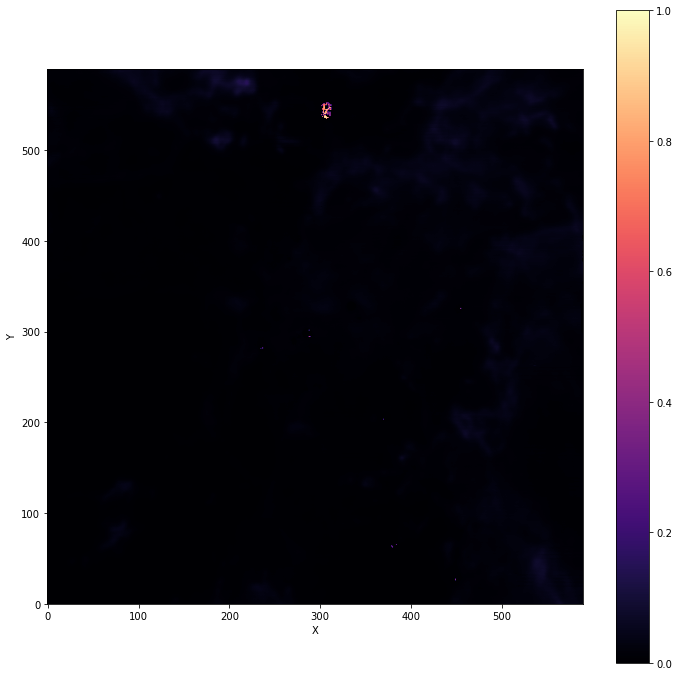

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))



plt.imshow(sb, cmap='magma')

cbar = plt.colorbar()
#cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.gca().invert_yaxis()

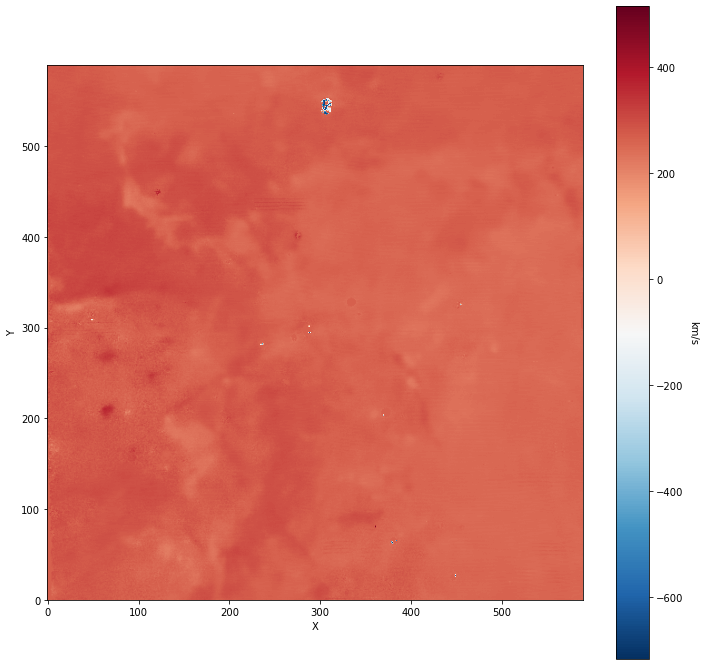

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.gca().invert_yaxis()

In [12]:
dffx=pd.DataFrame(sb)
dffx=dffx.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})
RV=pd.DataFrame(vv)
RV=RV.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})

In [13]:
data=RV
data['I']=dffx.I
data.describe()

,X,Y,RV,I
count,348100.000000,348100.000000,348100.000000,348100.000000
mean,294.500000,294.500000,268.273880,0.011894
std,170.318329,170.318329,23.150626,0.017448
min,0.000000,0.000000,-715.899253,0.000000
25%,147.000000,147.000000,255.298015,0.003802
50%,294.500000,294.500000,266.647394,0.007572
75%,442.000000,442.000000,279.830816,0.015702
max,589.000000,589.000000,514.945087,1.000000


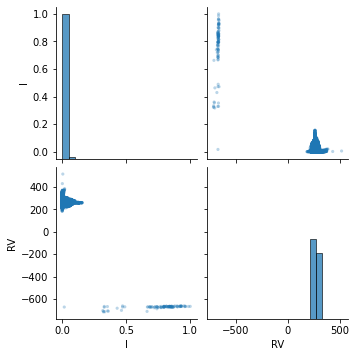

In [14]:
sns.pairplot(data, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [15]:
mI=(data.I>0)&(data.I<0.25)&(data.RV>0)&(data.RV<400)

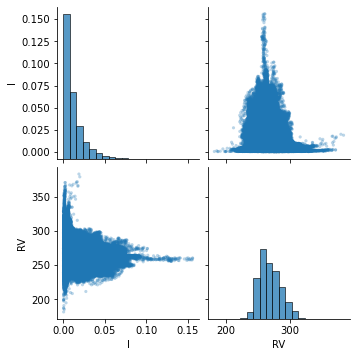

In [16]:
sns.pairplot(data[mI], 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

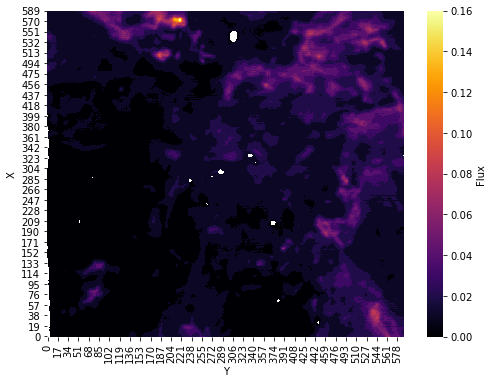

In [17]:

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot()

datal=data[mI].copy()
#datal.I=np.log10(datal.I)

datal.X=datal.X.astype(int)
sb=(datal.round(2)).pivot(index='X', columns='Y', values='I')
sns.heatmap(sb, cmap="inferno",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()


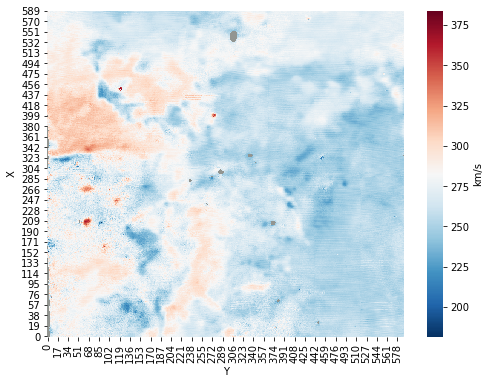

In [18]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

vv=(datal.round(2)).pivot(index='X', columns='Y', values='RV')
sns.heatmap(vv, cmap="RdBu_r",cbar_kws={'label': 'km/s'})

ax.set_facecolor('xkcd:gray')

plt.gca().invert_yaxis()

In [19]:
##Open results.json file
##Path and name
##Load results
data = json.load(open(str(datapath_res) + '/' + name_data + ".json"))
##load  parameters derived from the fit
r0 = data["results_2sig"]['r0'][0] #pc
s0 = data["results_2sig"]['s0'][0] #pc
m = data["results_2sig"]['m'][0] #-
mer = data["results_2sig"]['m'][1] #-
sig2 = data["results_2sig"]['sig2'][0] #km^2/s^2
noise = data["results_2sig"]['noise'][0] #km^2/s^2
box_size = data["properties"]['box_size']
r0,s0,m,mer,sig2,box_size

(2.6237051258392468,
 0.15150427534672997,
 0.6433982221797995,
 0.060213500362909844,
 306.66801614447365,
 31.512889272119835)

mf = ~np.isfinite(sb) | (sb < 0.0)
sb[mf] = 0.0
sb /= sb.max()
sb /= np.nanmean(sb)

In [20]:
##nan values to mean velocity values
vmed = np.nanmedian(vv)
mv = np.isfinite(vv)
vv[~mv] = vmed

In [21]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU())
new_hdul.append(fits.ImageHDU(sb))
new_hdul.append(fits.ImageHDU(vv))

In [22]:
hdr = new_hdul[0].header

In [23]:
hdr ['CDELT1'] = (-pix / (60*60), '[deg] Coordinate increment at reference point')
hdr ['CDELT2'] = (pix / (60*60), '[deg] Coordinate increment at reference point')
hdr['CUNIT1']  = ('deg' , 'Units of coordinate increment and value' )      
hdr['CUNIT2']  = ('deg' , 'Units of coordinate increment and value'  )
hdr['CTYPE1']  = ('RA---CAR', 'Right ascension, plate caree projection  ')
hdr['CTYPE2']  = ('DEC--CAR', 'Declination, plate caree projection   ')
hdr['targname']  = ('Orion', 'Target name   ')
hdr['distance']  = (distance, 'Distance to target   ')
hdr['pix'] = (pix, 'arcsec.pixel^{-1}')

In [24]:
sb = new_hdul[1].data.astype(float)
vv = new_hdul[2].data.astype(float)

In [25]:
new_hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1                1 ImageHDU         7   (590, 590)   float64   
  2                1 ImageHDU         7   (590, 590)   float64   


In [26]:
distance

50000

In [27]:
##Tutorial data
##img_hdu = create_fits_hdu(img, pixel_scale, beamfwhm, imshape, restfreq, bunit)
#img_hdu = create_fits_hdu(vv,pix*u.arcsec,1 * u.arcsec, vv.shape, 1 * u.Hz, u.K)
#img_hdu.header
#pspec = PowerSpectrum(img_hdu, distance=distance* u.pc) 

Spatial Power Spectrum

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1216.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):           3.18e-98
Time:                        18:14:42   Log-Likelihood:                -5.7499
No. Observations:                 253   AIC:                             15.50
Df Residuals:                     251   BIC:                             22.57
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4240      0.054    101.207      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


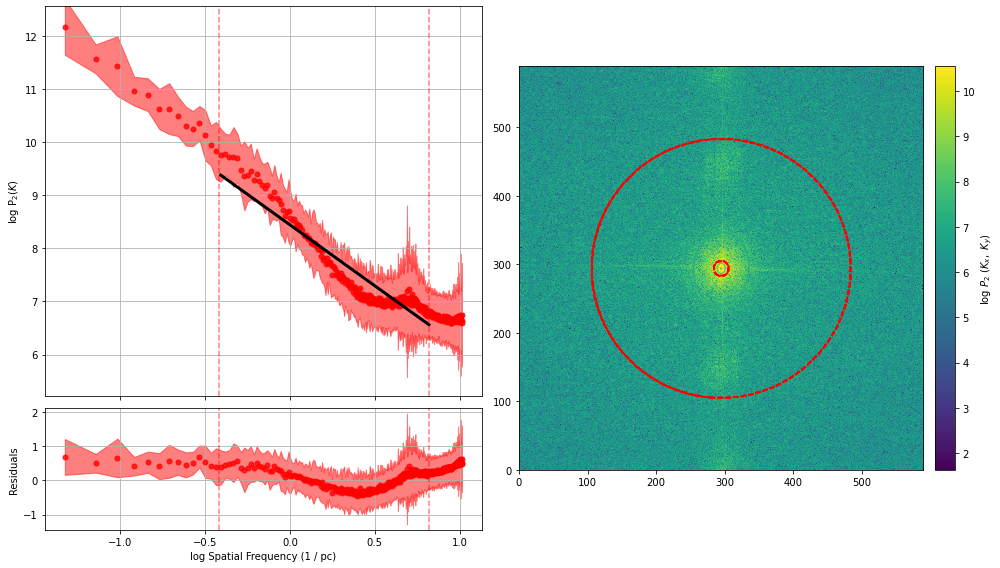

In [28]:
plt.figure(figsize=(14, 8))
pspec = PowerSpectrum(vv, header = hdr, distance = distance* u.pc) 
pspec.run(verbose=True, xunit = u.pc**-1, low_cut=(r0*u.pc)**-1, high_cut=(s0*u.pc)**-1)

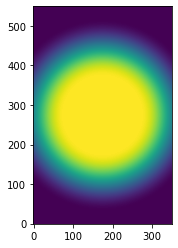

In [29]:
from turbustat.statistics.apodizing_kernels import \
   (CosineBellWindow, TukeyWindow, HanningWindow, SplitCosineBellWindow)

taper = HanningWindow()
taper3 = SplitCosineBellWindow(alpha=0.85, beta=0.55)
shape = (550, 350)
tap = taper3(shape)
plt.imshow(tap, cmap='viridis', origin='lower')  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     556.6
Date:                Wed, 25 Jan 2023   Prob (F-statistic):           4.12e-57
Time:                        18:14:49   Log-Likelihood:                 10.153
No. Observations:                 183   AIC:                            -16.31
Df Residuals:                     181   BIC:                            -9.888
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0624      0.086     58.738      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


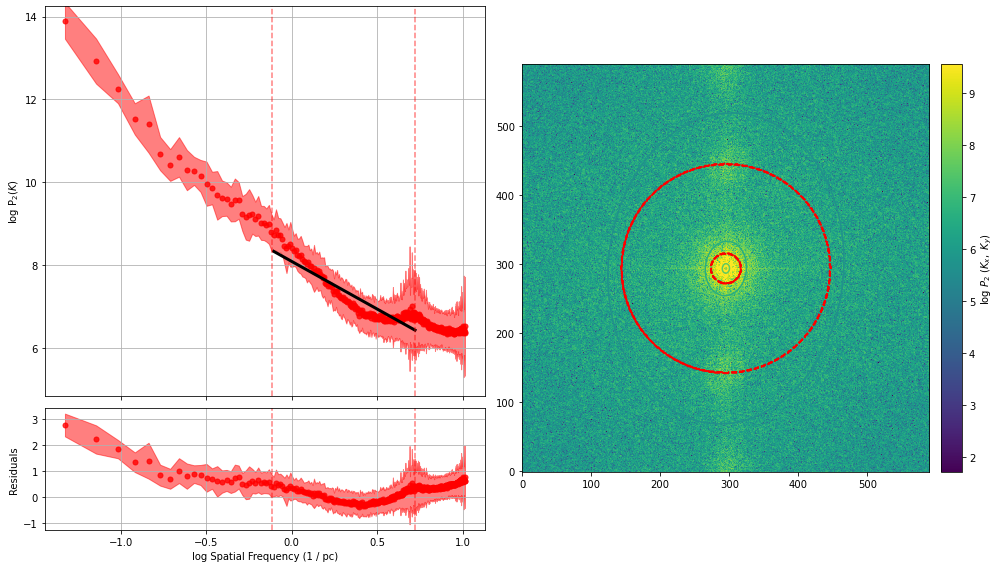

In [30]:
##NOTE 1: IDK why but the fit is done in pixel units despite introducing xunit as parsec. To compensate for this I need 
##to introduce a corr factor. To kinda avoid this I repeat the the WLS using the correct 'x' units and using 
##the derived new fit parameters in the comparison plots. 
##NOTE 2: this is no problem for NGC 604 since the correction factor is similar to 1 since 
## 0.26 (arcsec/pix) * 4.07 (pc/arsec)= 1.05

plt.figure(figsize=(14, 8))
pspec = PowerSpectrum(vv, header = hdr, distance = distance* u.pc) 
pspec.run(verbose=True, xunit = u.pc**-1, low_cut=(0.5*r0*u.pc)**-1, high_cut=(1.25*s0*u.pc)**-1,
           apodize_kernel='splitcosinebell', alpha=0.85, beta=0.55)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\base_pspec2.py:186: UserWarning: Not enough points to fit to. Ignoring break.
  warnings.warn("Not enough points to fit to." +


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     2836.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):          1.51e-142
Time:                        18:14:51   Log-Likelihood:                -14.441
No. Observations:                 264   AIC:                             32.88
Df Residuals:                     262   BIC:                             40.03
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2998      0.043    123.686      0.0

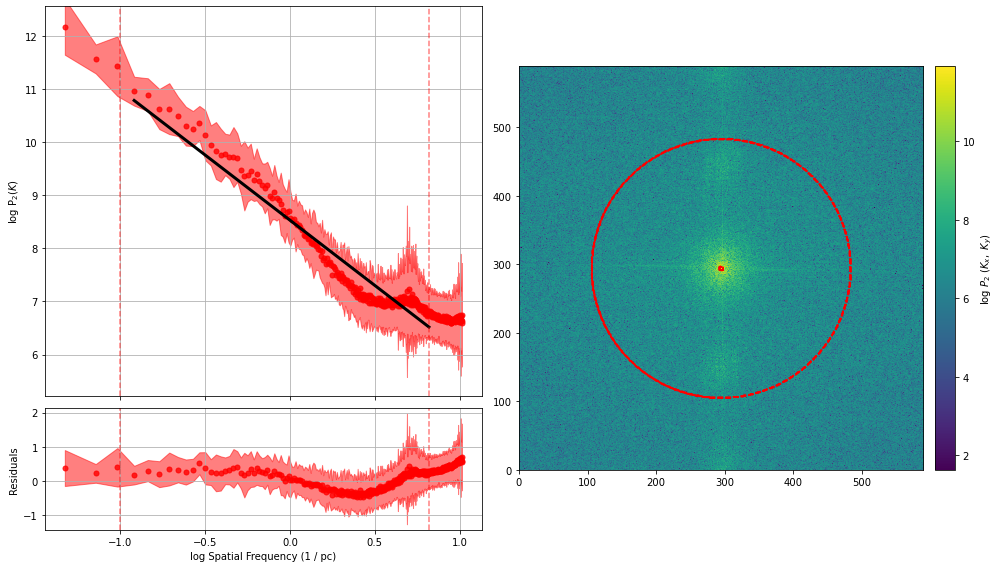

In [31]:
##NOTE 1: IDK why but the fit is done in pixel units despite introducing xunit as parsec. To compensate for this I need 
##to introduce a corr factor. To kinda avoid this I repeat the the WLS using the correct 'x' units and using 
##the derived new fit parameters in the comparison plots. 
##NOTE 2: this is no problem for NGC 604 since the correction factor is similar to 1 since 
## 0.26 (arcsec/pix) * 4.07 (pc/arsec)= 1.05

plt.figure(figsize=(14, 8))
pspec1 = PowerSpectrum(vv, header = hdr, distance=distance * u.pc) 
pspec1.run(verbose=True, xunit=(u.pc)**-1, low_cut=0.1*(u.pc)**-1, high_cut=(1/s0)*(u.pc)**-1,
          fit_kwargs={'brk': (1/r0)*(u.pc)**-1, 'log_break': False}, fit_2D=False)  

Delta-Variance

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            WLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     21.56
Date:                Wed, 25 Jan 2023   Prob (F-statistic):           7.35e-05
Time:                        18:16:15   Log-Likelihood:                 14.054
No. Observations:                  30   AIC:                            -24.11
Df Residuals:                      28   BIC:                            -21.30
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3133      0.139     -2.252      0.0

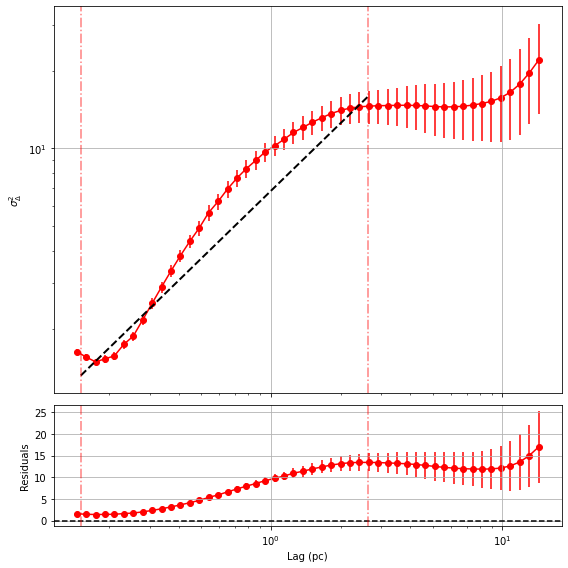

In [32]:
##NOTE 1: IDK why but the fit is done in pixel units despite introducing xunit as parsec. To compensate for this I need 
##to introduce a corr factor. To kinda avoid this I repeat the the WLS using the correct 'x' units and using 
##the derived new fit parameters in the comparison plots. 
##NOTE 2: this is no problem for NGC 604 since the correction factor is similar to 1 since 
## 0.26 (arcsec/pix) * 4.07 (pc/arsec)

dvar = tss.DeltaVariance(vv, header = hdr, distance=distance* u.pc,nlags=50)
plt.figure(figsize=(8, 8))
dvar.run(verbose=True, boundary="fill",xunit=u.pc, xlow=s0*u.pc, xhigh=r0*u.pc)

In [33]:
##Plots
sns.set_context("talk", font_scale=1.1)
#plt.style.use(["seaborn-poster",])

In [34]:
x = np.array(pspec.freqs*(corr**-1))
y = np.array(pspec.ps1D)
y_er = np.array(pspec.ps1D_stddev)

log_x = np.log10(x)
log_y = np.log10(y)
log_y_er = np.log10(y_er)

In [35]:
i = 10
f = len(pspec.ps1D)-1
#f = 36

In [36]:
intr=linregress(x[i:f], y[i:f])
intr.slope,intr.stderr,intr.intercept,intr.rvalue

(-106030389.60930035,
 17040645.997843597,
 747894713.1528109,
 -0.295387314125024)

In [37]:
intrl=linregress(log_x[i:f], log_y[i:f])
intrl.slope,intrl.stderr,intrl.intercept,intrl.rvalue

(-2.023761512136997, 0.038847435985304, 8.160610285938859, -0.9328164627034313)

[None, None]

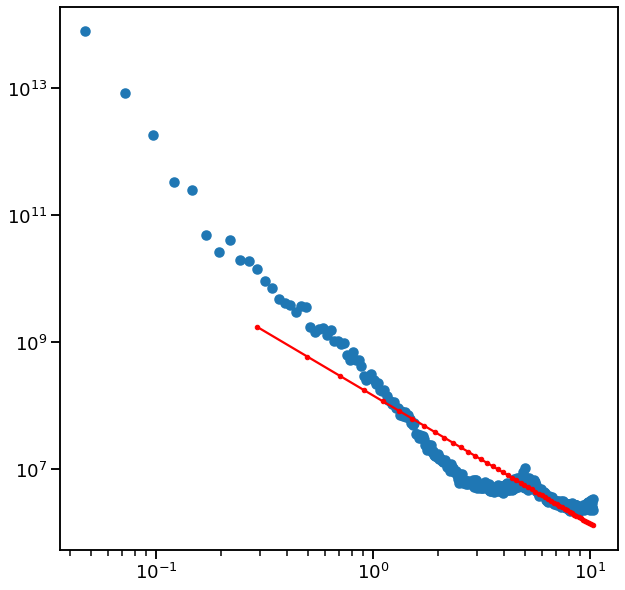

In [38]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x,y)
#ax.plot(x,y)

xgrid = np.linspace(x[i],x[f])
#ax.plot(xgrid, xgrid*intr.slope + intr.intercept, color = 'k')
ax.plot(xgrid, 10**(intrl.intercept)*(xgrid**intrl.slope), color ='r', marker = '.')


ax.set(xscale = 'log', yscale = 'log')

In [39]:
x,y,z=log_x[i:f],log_y[i:f],log_y_er[i:f]
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     2714.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):          1.27e-181
Time:                        18:16:17   Log-Likelihood:                -42.494
No. Observations:                 407   AIC:                             88.99
Df Residuals:                     405   BIC:                             97.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1606      0.028    295.645      0.0

In [40]:
x,y,z=log_x[i:f],log_y[i:f],log_y_er[i:f]
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=z)
resultsw = model.fit()
print(resultsw.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            WLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     3148.
Date:                Wed, 25 Jan 2023   Prob (F-statistic):          4.25e-193
Time:                        18:16:17   Log-Likelihood:                -58.368
No. Observations:                 407   AIC:                             120.7
Df Residuals:                     405   BIC:                             128.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2261      0.026    314.177      0.0

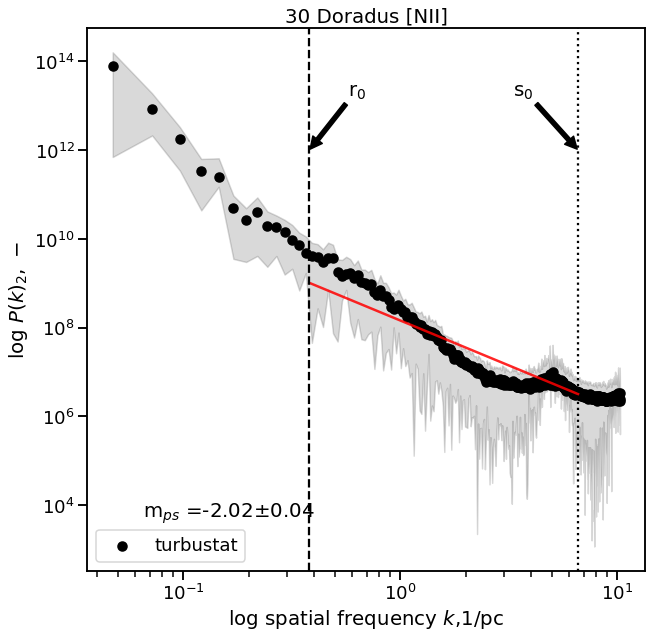

In [41]:
fig, (ax) = plt.subplots(
    1,
    1,
    sharey=False,
    figsize=(10, 10),
)

##spatial power spectra
ax.scatter(pspec.freqs*(corr**-1),pspec.ps1D, color = 'k',label = 'turbustat')

##spatial power spectra errors
yy1 = pspec.ps1D+pspec.ps1D_stddev
yy2 = np.sqrt((pspec.ps1D-pspec.ps1D_stddev)**2)
ax.fill_between(pspec.freqs*(corr**-1), yy1, yy2, alpha = 0.15, zorder = 0, color = 'k')

##ps-fit
xgrid = np.logspace(np.log10(1/r0),np.log10(1/s0),100)
ax.plot(xgrid,(10**(results.params[0]))*(xgrid**results.params[1]), color = 'r', alpha = 0.85, linewidth = 2.5)

##seeing and corelation length
ax.axvline(1/r0, c="k", linestyle = '--')
ax.axvline(1/s0, c="k", linestyle = ':')

##annotations
ax.text(.1, .10,'m$_{ps}$ =' + str(np.round(results.params[1],2)) + '$\pm$' + str(np.round(results.bse[1],2)), transform=ax.transAxes)

ax.annotate('r$_0$', xy=(1/r0, 1e12),  xycoords='data',
           xytext=(0.5, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

ax.annotate('s$_0$', xy=(1/s0, 1e12),  xycoords='data',
            xytext=(0.80, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

plt.title(name_plt + ' '+ em_line)
plt.legend(loc = 0)

##config
ax.set(xscale='log', yscale='log', 
       xlabel='log spatial frequency $k$,1/pc',
       ylabel=r'log $P(k)_2,\ \mathrm{-}$'
      )

plt.savefig('Imgs//'+ 'ps_'+ name_exp + element +  '.pdf', bbox_inches='tight')

In [42]:


x = np.array(dvar.lags*corr)
#x = np.array(dvar.lags)
y = np.array(dvar.delta_var)
y_er = np.array(dvar.delta_var_error)

log_x = np.log10(x)
log_y = np.log10(y)
log_y_er = np.log10(y_er)

In [43]:
i = 0
#f = len(dvar.lags)-1
f = 36

In [44]:
intr=linregress(x[i:f], y[i:f])
intr.slope,intr.stderr,intr.intercept,intr.rvalue

(4.3424075825216635,
 0.37086722771935254,
 3.0034296518957184,
 0.8951429815786375)

In [45]:
intrl=linregress(log_x[i:f], log_y[i:f])
intrl.slope,intrl.stderr,intrl.intercept,intrl.rvalue

(0.8313734533132306,
 0.03885239436360635,
 0.8839926487385913,
 0.9648202934871617)

[None, None]

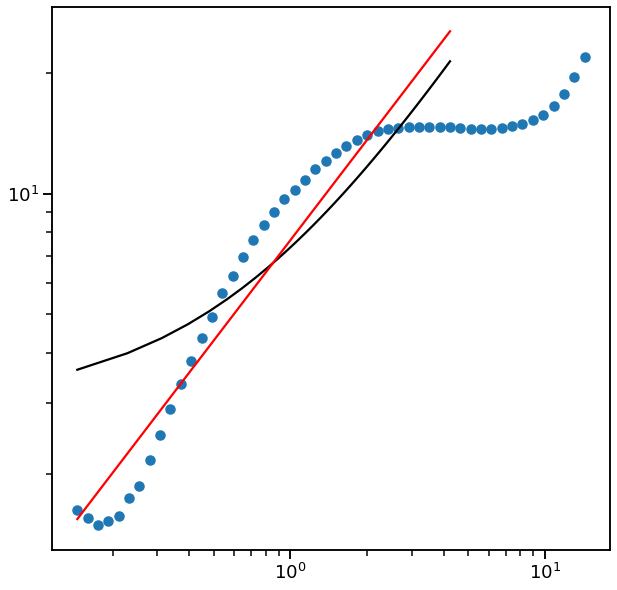

In [46]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x,y)
#ax.plot(x,y)

xgrid = np.linspace(x[i],x[f])
ax.plot(xgrid, xgrid*intr.slope + intr.intercept, color = 'k')
ax.plot(xgrid, 10**(intrl.intercept)*(xgrid**intrl.slope), color ='r')


ax.set(xscale = 'log', yscale = 'log')

In [47]:
x,y,z=log_x[i:f],log_y[i:f],log_y_er[i:f]
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     457.9
Date:                Wed, 25 Jan 2023   Prob (F-statistic):           2.64e-21
Time:                        18:16:19   Log-Likelihood:                 33.391
No. Observations:                  36   AIC:                            -62.78
Df Residuals:                      34   BIC:                            -59.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8840      0.017     51.623      0.0

In [48]:
x,y,z=log_x[i:f],log_y[i:f],log_y_er[i:f]
X = sm.add_constant(x)
model = sm.WLS(y, X,weights=1/z)
resultsw = model.fit()
print(resultsw.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            WLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 25 Jan 2023   Prob (F-statistic):                nan
Time:                        18:16:19   Log-Likelihood:                    nan
No. Observations:                  36   AIC:                               nan
Df Residuals:                      36   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:729: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:727: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1617: RuntimeWarning: invalid value encountered in sign
  term2 = np.sign(denom) * np.where(denom == 0.0, np.nan,
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:762: RuntimeWarning: invalid valu

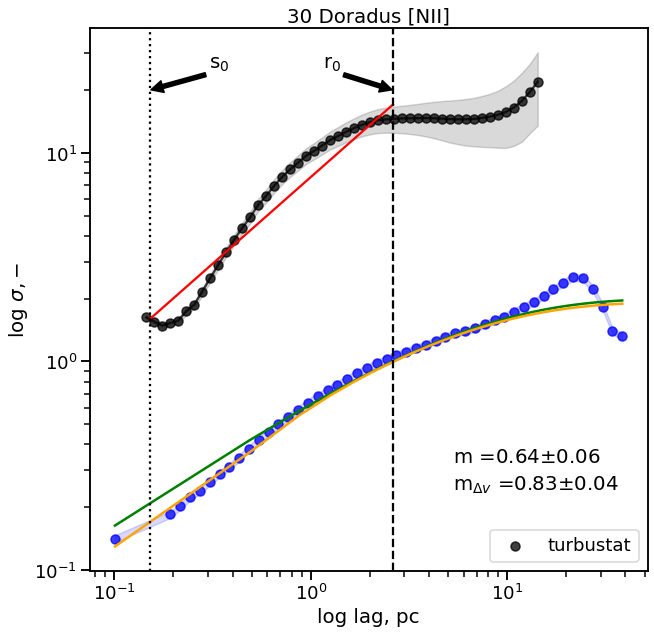

In [49]:
fig, (axx) = plt.subplots(
    1,
    1,
    sharey=False,
    figsize=(10, 10),
)

##delta-variance
axx.scatter(dvar.lags*corr,dvar.delta_var,alpha = 0.75, color = 'k', zorder = 0, label = 'turbustat')
axx.plot(dvar.lags*corr,dvar.delta_var,alpha = 0.75, color = 'k', zorder = 0)
yy1 = dvar.delta_var+dvar.delta_var_error
yy2 = dvar.delta_var-dvar.delta_var_error
axx.fill_between(dvar.lags*corr, yy1, yy2, alpha = 0.15, zorder = 0, color = 'k')

##delta-fit
xgrid = np.linspace(s0,r0,100)
#axx.plot(xgrid,10**(-1.54)*(xgrid**dvar.slope), color = 'r', alpha = 0.75, linewidth = 2.5)
axx.plot(xgrid, 10**(results.params[0])*(xgrid**results.params[1]), color ='r')


#xgrid = np.logspace(np.log10(s0),np.log10(r0),100)
#axx.plot(xgrid,-1.54+(xgrid*dvar.slope), color = 'r', alpha = 0.75, linewidth = 2.5)


##observational structure function: average between sig obs and sig derived normalized
b_sigo = np.array(data['B'])/data['preres']['sig2']
b_sigd = np.array(data['B'])/sig2
b_m = ( b_sigo + b_sigd ) / 2
axx.scatter(data['r'],b_m, color = 'b', alpha = 0.75, marker = 'o')
axx.fill_between(data['r'], b_sigo , b_sigd, alpha = 0.15, zorder = 0, color = 'b')


##model structure function
rgrid = np.linspace(np.array(data['r']).min(),np.array(data['r']).max(),100)
axx.plot(rgrid, bfunc.bfunc00s(rgrid, r0, sig2, m)/sig2, color="green",  linewidth = 2.5)
axx.plot(rgrid, bfunc.bfunc04s(rgrid, r0, sig2, m, s0, noise, box_size)/sig2, color="orange",  linewidth = 2.5)

##annotations
axx.text(.65, .10,'m$_{Δv}$ =' + str(np.round(results.params[1],2)) + '$\pm$' + str(np.round(results.bse[1],2)), transform=ax.transAxes)
axx.text(.65, .15,'m =' + str(np.round(m,2)) + '$\pm$' + str(np.round(mer,2)), transform=ax.transAxes)

axx.annotate('r$_0$', xy=(r0, 20),  xycoords='data',
           xytext=(0.45, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

axx.annotate('s$_0$', xy=(s0, 20),  xycoords='data',
            xytext=(0.25, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

##config
axx.set(xscale='log', yscale='log', 
        xlabel='log lag, pc', 
        ylabel=r'log $σ, \mathrm{-}$')

axx.axvline(r0, c="k", linestyle = '--')
axx.axvline(s0, c="k", linestyle = ':')

plt.title(name_plt + ' '+ em_line)
plt.legend(loc = 4)

plt.savefig('Imgs//'+ 'sf_'+ name_exp + element +  '.pdf', bbox_inches='tight')

In [50]:
text_file_0 = open("path-observations.txt", "r")
path_obs = text_file_0.read()
data_file = 'MUSE-Dor-N.fits'
datapath_obs = Path(path_obs).expanduser()
hdulist = fits.open(str(datapath_obs)+'/'+data_file)

In [51]:
n = None
sb = hdulist[1].data[:n, :n].astype(np.float64)

In [52]:
## Replace spurious values in the arrays
mm = ~np.isfinite(sb) | (sb < 0.0)
mm = mm | (sb > 6e4)
sb[mm] = 0.0
#ss[m] = 0.0
#sb /= sb.max()

PDF/CFD

In [53]:
#header=0
input_data = (sb,hdr) 

Optimization terminated successfully.
         Current function value: 0.993829
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -3.5983e+05
Model:                     Likelihood   AIC:                         7.197e+05
Method:            Maximum Likelihood   BIC:                         7.197e+05
Date:                Wed, 25 Jan 2023                                         
Time:                        18:16:24                                         
No. Observations:              362066                                         
Df Residuals:                  362064                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

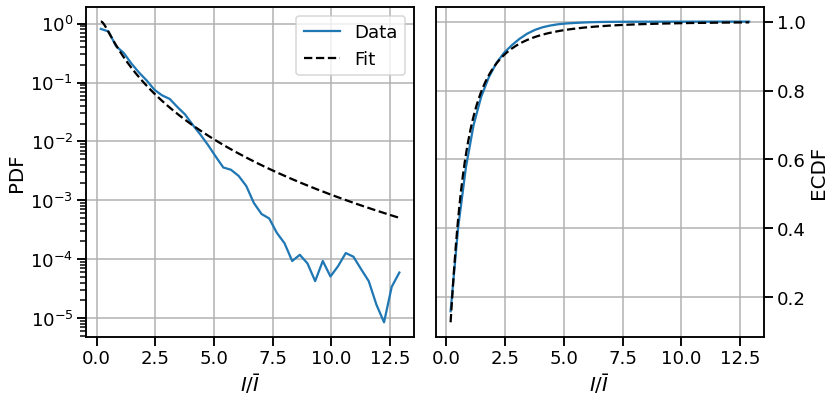

In [54]:
pdf_mom0 = tss.PDF(input_data, min_val=0.0, bins=40, normalization_type= "normalize_by_mean" )
plt.figure(figsize=(12, 6))
pdf_mom0.run(verbose=True)

In [55]:
from scipy.stats import lognorm
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

In [56]:
LN = lognorm(s=1.0, scale=np.exp(1.0))

[None]

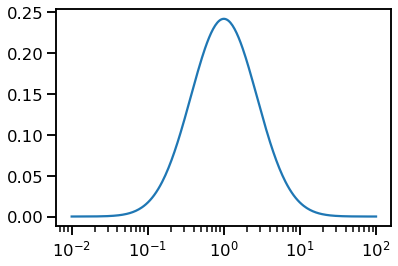

In [57]:
x = np.logspace(-2.0, 2.0, 300)
fig, ax = plt.subplots()
ax.plot(x, LN.pdf(x))
ax.set(xscale="log")

In [58]:
len(pdf_mom0.bins)

40

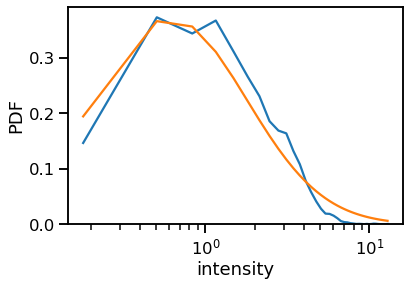

In [59]:
fig, ax = plt.subplots()
s, scale = pdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = pdf_mom0.bins
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [60]:
pdf_mom0.model_params

array([1.0723104, 0.6096165])

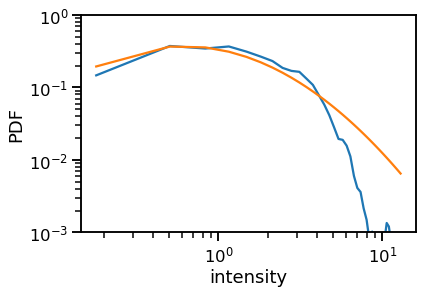

In [61]:
fig, ax = plt.subplots()
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    yscale="log",
    ylim=[1e-3, 1.0],
);

Optimization terminated successfully.
         Current function value: 17.636076
         Iterations: 58
         Function evaluations: 140
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -6.3854e+06
Model:                     Likelihood   AIC:                         1.277e+07
Method:            Maximum Likelihood   BIC:                         1.277e+07
Date:                Wed, 25 Jan 2023                                         
Time:                        18:16:34                                         
No. Observations:              362066                                         
Df Residuals:                  362064                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

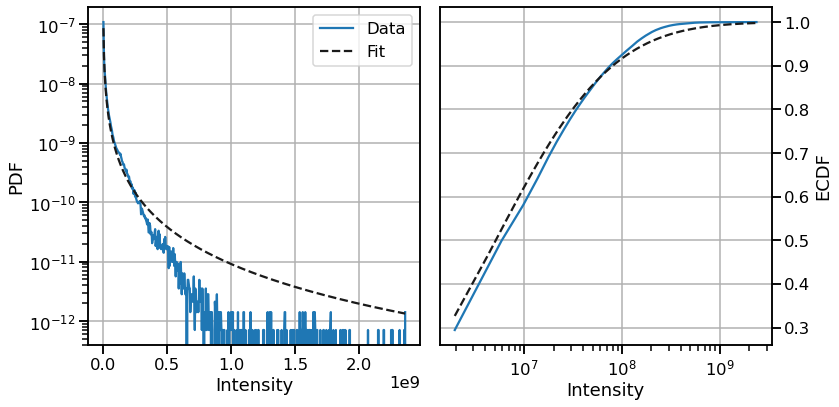

In [62]:
wpdf_mom0 = tss.PDF(input_data, min_val=0.0, weights=sb)
plt.figure(figsize=(12, 6))
wpdf_mom0.run(verbose=True)

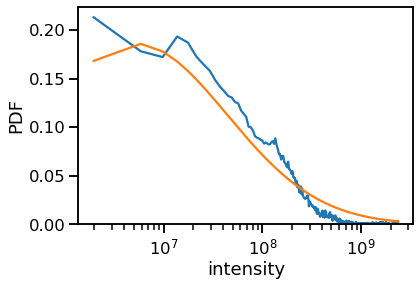

In [63]:
fig, ax = plt.subplots()
s, scale = wpdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = wpdf_mom0.bins
ax.plot(x, x*wpdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [64]:
wpdf_mom0.model_params

array([2.14462086e+00, 5.14828657e+06])

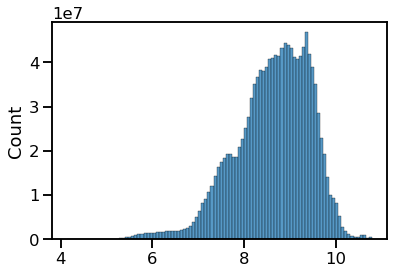

In [65]:
m1 = np.isfinite(sb) & (sb > 0.0)
sns.histplot(x=np.log(sb[m1]), kde=False, weights=sb[m1].astype(float), bins=100)

In [66]:
H, edges = np.histogram(np.log(sb[m1]), weights=sb[m1], bins=100, range=[-4.0, 2.5], density=True)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[Text(0, 0.5, 'PDF'), Text(0.5, 0, '$\\ln (S/S_0)$')]

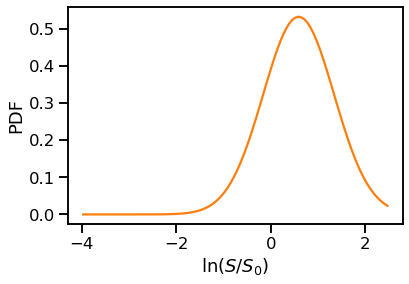

In [67]:
fig, ax = plt.subplots()
centers = 0.5*(edges[:-1] + edges[1:])
ax.plot(centers, H)
LN = lognorm(s=0.75,scale=1.8)
ax.plot(centers, np.exp(centers)*LN.pdf(np.exp(centers)))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="PDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

[Text(0, 0.5, 'CDF'), Text(0.5, 0, '$\\ln (S/S_0)$')]

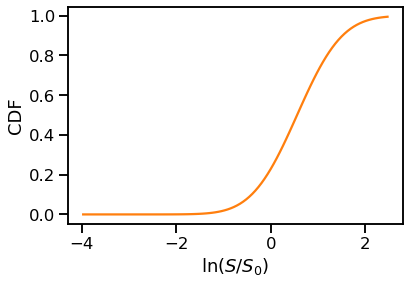

In [68]:
cdf = np.cumsum(H)*(centers[1] - centers[0])
fit = np.exp(centers)*LN.pdf(np.exp(centers))
cdf_fit = np.cumsum(fit)*(centers[1] - centers[0])

fig, ax = plt.subplots()
ax.plot(centers, cdf)
ax.plot(centers, cdf_fit)
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

[None,
 (0.0003333333333333333, 3000.0),
 Text(0, 0.5, 'CDF / (1 $-$ CDF)'),
 Text(0.5, 0, '$\\ln (S/S_0)$')]

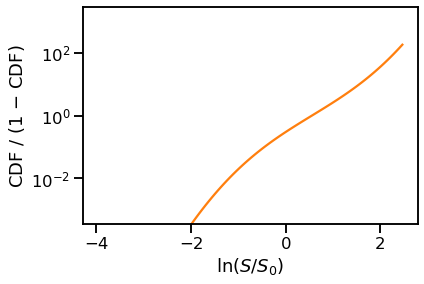

In [69]:
fig, ax = plt.subplots()
ax.plot(centers, cdf/(1 - cdf))
ax.plot(centers, cdf_fit/(1 - cdf_fit))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF / (1 $-$ CDF)",
    yscale="log",
    ylim=[1e-3/3, 3e3],
)

In [70]:
#from sbfluct import sbfluct
#sbfluct(sb, 1e-8, 2, "604")

In [71]:

#sb = fits.open(datapath_obs / flux_map)[0].data.astype(float)
fmin = 1e-8
kmax = 4

In [72]:
resamples = [2, 4, 8, 16, 32, 64]

In [73]:
m = (sb > fmin) & np.isfinite(sb)
w = np.ones_like(sb)

In [74]:
for n in resamples[: kmax]:
    [sb,], m, w = downsample([sb,],
        m,
        weights=w,
        mingood=1,
        )
    
sb /= np.mean(sb[m])

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\turbustat_analysis\rebin_utils.py:129: RuntimeWarning: invalid value encountered in true_divide
  (


In [75]:
smin, smax = -3.1, 3.1

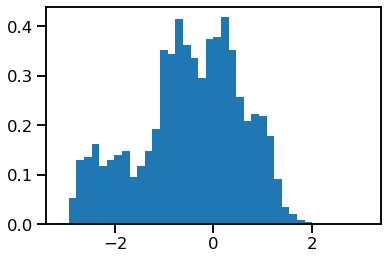

In [76]:
H, edges, patches = plt.hist(
            np.log(sb[m]),
            # weights=s[m],
            density=True,
            bins=40,
            range=[-3.1, 3.1],)



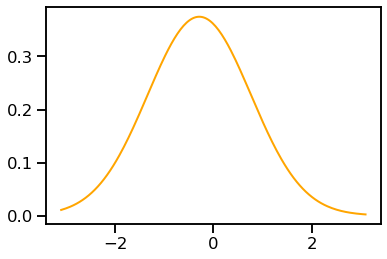

In [77]:
# Calculate bin centers
x = 0.5 * (edges[:-1] + edges[1:])
# Fit Gaussian
g = models.Gaussian1D(amplitude=H.max(), stddev=0.5)
core = H > 0.01
g = fitter(g, x, H)
sigS = np.sqrt(np.exp(g.stddev.value ** 2) - 1)
esigS = 0.5 * np.sqrt(np.exp(g.mean.value ** 2) - 1)
xx = np.linspace(smin, smax, 200)

plt.plot(xx, g(xx), "orange", lw=2)


In [78]:
X = np.exp(xx)
Xmean = np.average(X, weights=g(xx))
Xvariance = np.average((X - Xmean) ** 2, weights=g(xx))
eps_rms = np.sqrt(Xvariance) / Xmean
eps_rms 

1.3060388929489475

In [79]:
##turbustat results
x = pdf_mom0.bins 
s, scale = pdf_mom0.model_params
LN = lognorm(s=s, scale=scale)

Xmean = np.average(x, weights=x*LN.pdf(x))
Xvariance = np.average((x - Xmean) ** 2, weights=x*LN.pdf(x))
eps_rms_t = np.sqrt(Xvariance) / Xmean
eps_rms_t 

0.9463567891428395

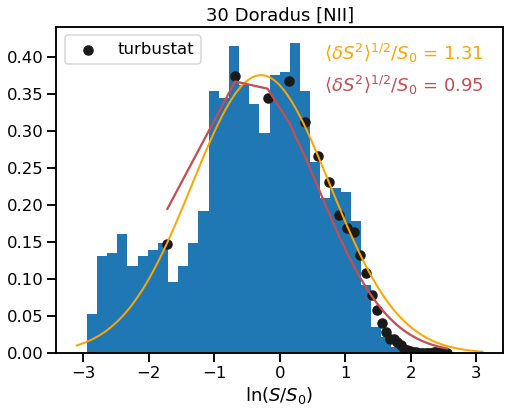

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))


##pdf
H, edges, patches = ax.hist(
            np.log(sb[m]),
            # weights=s[m],
            density=True,
            bins=40,
            range=[-3.1, 3.1],)

##lognorm fit
ax.plot(xx, g(xx), "orange", lw=2)


##pdf turbustat and fit
ax.scatter(np.log(x), x*pdf_mom0.pdf, color = 'k', zorder = 2, label = 'turbustat')
ax.plot(np.log(x), x*LN.pdf(x), color = 'r')

ax.text(.6, 0.9,r"$\langle \delta S^2 \rangle^{1/2} / S_0$ = " + str(np.round(eps_rms ,2)), transform=ax.transAxes, color = 'orange')
ax.text(.6, 0.8,r"$\langle \delta S^2 \rangle^{1/2} / S_0$ = " + str(np.round(eps_rms_t ,2)), transform=ax.transAxes, color = 'r')

plt.title(name_plt + ' '+ em_line)
ax.legend(loc = 2)

ax.set(
    xlabel="$\ln (S/S_0)$",

)

plt.savefig('Imgs//'+ 'bf_'+ name_exp + element +  '.pdf', bbox_inches='tight')

In [81]:
!jupyter nbconvert --to script --no-prompt ts-MUSE-Dor-N.ipynb

[NbConvertApp] Converting notebook ts-MUSE-Dor-N.ipynb to script
[NbConvertApp] Writing 18839 bytes to ts-MUSE-Dor-N.py


In [82]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 144.52027130126953 seconds ---
